In [142]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import os
from abc import ABC, abstractmethod
from collections import OrderedDict
import glob
import matplotlib.pyplot as plt
from PIL import Image

import random
import argparse
import os
from collections import defaultdict
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader 
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
# from utils.dataset import XYDataset
# from utils.util import read_yaml_config, transforms, reverse_image_normalize

device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')


In [143]:
# Training settig
NUM_EPOCHS = 400
LAMBDA_Y = 1
LEARNING_RATE = 0.0002
SAVE_MODEL = True
SAVE_MODEL_EPOCH_STEP = 5
VISUALIZATION_STEP = 350
LOAD_MODEL = False
LOAD_EPOCH = 0

# Ineference setting 
MODEL_VERSION = "latast"
SAVE_ORIGINAL_IMAGE = False

In [144]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, unaligned=False, mode="train"):
        self.transform = transform
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, "%sA" % mode) + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, "%sB" % mode) + "/*.*"))

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))
    
    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return item_B, item_A

In [145]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
    transforms.Resize((256,256)),
    transforms.RandomCrop((256,256)),
    transforms.RandomHorizontalFlip(),
])

In [146]:
dataset = ImageDataset("/home/NAS_mount2/jwkim/data/facades_train", unaligned=True, transform=transform)
dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True, 
    num_workers=16
)

val_dataset = ImageDataset("/home/NAS_mount2/jwkim/data/facades_test", unaligned=True, transform=transform, mode='test')
val_dataloader = DataLoader(
    val_dataset,
    batch_size=5,
    shuffle=True, 
    num_workers=1
)

(-0.5, 255.5, 255.5, -0.5)

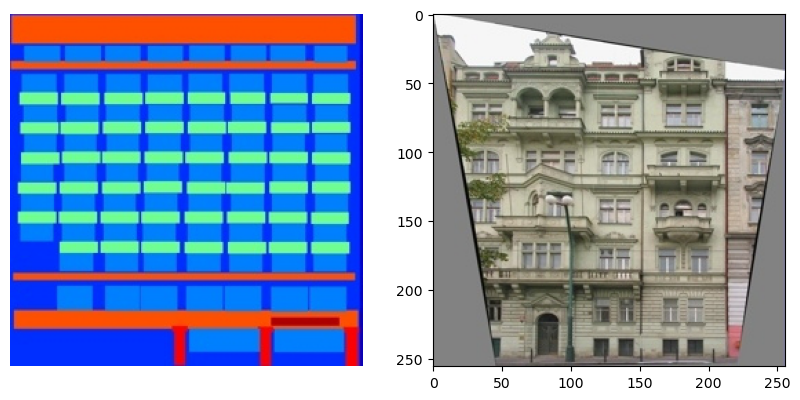

In [147]:
a,b = dataset[0]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(0.5*a+0.5))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*b+0.5))
plt.axis('on')

In [148]:
class Downsample(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.reflectionpad = nn.ReflectionPad2d(1)
        self.conv = nn.Conv2d(features, features, kernel_size=3, stride=2)

    def forward(self, x):
        x = self.reflectionpad(x)
        x = self.conv(x)
        return x
    
class Upsample(nn.Module):
    def __init__(self, features):
        super().__init__()
        layers = [
            nn.ReplicationPad2d(1),
            nn.ConvTranspose2d(features, features, kernel_size=4, stride=2, padding=3)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        return self.model(input)

In [149]:
class DiscriminatorBasicBlock(nn.Module):
    def __init__(self, in_features, out_features, do_downsample=True, do_instancenorm=True):
        super().__init__()

        self.do_downsample = do_downsample
        self.do_instancenorm = do_instancenorm

        self.conv = nn.Conv2d(in_features, out_features, kernel_size=4, stride=1, padding=1)
        self.leakyrelu = nn.LeakyReLU(0.2, True)

        if do_instancenorm:
            self.instancenorm = nn.InstanceNorm2d(out_features)

        if do_downsample:
            self.downsample = Downsample(out_features)
        
    def forward(self, x):
        x = self.conv(x)
        if self.do_instancenorm:
            x = self.instancenorm(x)
        x = self.leakyrelu(x)
        if self.do_downsample:
            x = self.downsample(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.block1 = DiscriminatorBasicBlock(in_channels, features, do_downsample=True, do_instancenorm=False)
        self.block2 = DiscriminatorBasicBlock(features, features * 2, do_downsample=True, do_instancenorm=True)
        self.block3 = DiscriminatorBasicBlock(features * 2, features * 4, do_downsample=True, do_instancenorm=True)
        self.block4 = DiscriminatorBasicBlock(features * 4, features * 8, do_downsample=False, do_instancenorm=True)
        self.conv = nn.Conv2d(features * 8, 1, kernel_size=4, stride=1, padding=1)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.conv(x)
        return x

    def set_requires_grad(self, requires_grad=False):
        for param in self.parameters():
            param.requires_grad = requires_grad


x = torch.randn((5, 3, 256, 256))
print(x.shape)
model = Discriminator(in_channels=3)
preds = model(x)
print(preds.shape)

torch.Size([5, 3, 256, 256])
torch.Size([5, 1, 30, 30])


In [150]:
class ResnetBlock(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.model = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(features, features, kernel_size=3),
            nn.InstanceNorm2d(features),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(features, features, kernel_size=3),
            nn.InstanceNorm2d(features)
        )

    def forward(self, x):
        return x + self.model(x)


class GeneratorBasicBlock(nn.Module):
    def __init__(self, in_features, out_features, do_upsample=False, do_downsample=False):
        super().__init__()
        
        self.do_upsample = do_upsample
        self.do_downsample = do_downsample

        if self.do_upsample:
            self.upsample = Upsample(in_features)
        self.conv = nn.Conv2d(in_features, out_features, kernel_size=3, stride=1, padding=1)
        self.instancenorm = nn.InstanceNorm2d(out_features)
        self.relu = nn.ReLU(True)
        if self.do_downsample:
            self.downsample = Downsample(out_features)
        
    def forward(self, x):
        if self.do_upsample:
            x = self.upsample(x)
        x = self.conv(x)
        x = self.instancenorm(x)
        x = self.relu(x)
        if self.do_downsample:
            x = self.downsample(x)
        return x
    
    def fordward_hook(self, x):
        if self.do_upsample:
            x = self.upsample(x)
        x_hook = self.conv(x)
        x = self.instancenorm(x_hook)
        x = self.relu(x)
        if self.do_downsample:
            x = self.downsample(x)
        return x_hook, x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64, residuals=9):
        super().__init__()
        self.residuals = residuals

        self.reflectionpad = nn.ReflectionPad2d(3)
        self.block1 = nn.Sequential(
                        nn.Conv2d(in_channels, features, kernel_size=7),
                        nn.InstanceNorm2d(features),
                        nn.ReLU(True)
                        )

        self.downsampleblock2 = GeneratorBasicBlock(features, features * 2, do_upsample=False, do_downsample=True)
        self.downsampleblock3 = GeneratorBasicBlock(features * 2, features * 4, do_upsample=False, do_downsample=True)

        self.resnetblocks4 = nn.Sequential(*[ResnetBlock(features * 4) for _ in range(residuals)])

        self.upsampleblock5 = GeneratorBasicBlock(features * 4, features * 2, do_upsample=True, do_downsample=False)
        self.upsampleblock6 = GeneratorBasicBlock(features * 2, features, do_upsample=True, do_downsample=False)

        self.block7 = nn.Sequential(
                        nn.ReflectionPad2d(3),
                        nn.Conv2d(features, in_channels, kernel_size=7),
                        nn.Tanh(),
                        )

    def append_sample_feature(self, feature, return_ids, return_feats, mlp_id=0, num_patches=256, patch_ids=None):
        B, H, W = feature.shape[0], feature.shape[2], feature.shape[3]
        feature_reshape = feature.permute(0, 2, 3, 1).flatten(1, 2) # B, F, C
        if patch_ids is not None:
            patch_id = patch_ids[mlp_id]
        else:
            patch_id = torch.randperm(feature_reshape.shape[1])
            patch_id = patch_id[:int(min(num_patches, patch_id.shape[0]))]
        x_sample = feature_reshape[:, patch_id, :].flatten(0, 1)

        return_ids.append(patch_id)
        return_feats.append(x_sample)

    def forward(self, x, encode_only=False, num_patches=256, patch_ids=None):
        if not encode_only:
            x = self.reflectionpad(x)
            x = self.block1(x)
            x = self.downsampleblock2(x)
            x = self.downsampleblock3(x)
            x = self.resnetblocks4(x)
            x = self.upsampleblock5(x)
            x = self.upsampleblock6(x)
            x = self.block7(x)
            return x

        else:
            return_ids = []
            return_feats = []
            mlp_id = 0

            x = self.reflectionpad(x)
            self.append_sample_feature(x, return_ids, return_feats, mlp_id=mlp_id, num_patches=num_patches, patch_ids=patch_ids)
            mlp_id += 1

            x = self.block1(x)
            
            x_hook, x = self.downsampleblock2.fordward_hook(x)
            self.append_sample_feature(x_hook, return_ids, return_feats, mlp_id=mlp_id, num_patches=num_patches, patch_ids=patch_ids)
            mlp_id += 1

            x_hook, x = self.downsampleblock3.fordward_hook(x)
            self.append_sample_feature(x_hook, return_ids, return_feats, mlp_id=mlp_id, num_patches=num_patches, patch_ids=patch_ids)
            mlp_id += 1

            for resnet_layer_id, resnet_layer in enumerate(self.resnetblocks4):
                x = resnet_layer(x)
                if resnet_layer_id in [0, 4]:
                    self.append_sample_feature(x, return_ids, return_feats, mlp_id=mlp_id, num_patches=num_patches, patch_ids=patch_ids)
                    mlp_id += 1

            return return_feats, return_ids


x = torch.randn((5, 3, 256, 256))
print(x.shape)
G = Generator()
x = G(x)
print(x.shape)

x = torch.randn((5, 3, 256, 256))
print(x.shape)
G = Generator()
feat_k_pool, sample_ids = G(x, encode_only=True, patch_ids=None) # positive/negative
feat_q_pool, _ = G(x, encode_only=True, patch_ids=sample_ids)    # query
print(len(feat_k_pool), len(feat_q_pool))

torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])
5 5


In [200]:
x = torch.randn((5, 3, 256, 256))
G = Generator()
feat_k_pool, sample_ids = G(x, encode_only=True, patch_ids=None) # positive/negative
feat_q_pool, _ = G(x, encode_only=True, patch_ids=sample_ids)    # query

In [212]:
len(sample_ids)

5

: 

In [151]:
class MLP(nn.Module):
    def __init__(self, input_nc, output_nc):
        super().__init__()
        self.mlp = nn.Sequential(*[
            nn.Linear(input_nc, output_nc),
            nn.ReLU(),
            nn.Linear(output_nc, output_nc)
        ])
    
    def forward(self, x):
        return self.mlp(x)


class Head(nn.Module):
    def __init__(self, in_channels=3, features=64, residuals=9):
        super().__init__()
        self.mlp_0 = MLP(3, 256)
        self.mlp_1 = MLP(128, 256)
        self.mlp_2 = MLP(256, 256)
        self.mlp_3 = MLP(256, 256)
        self.mlp_4 = MLP(256, 256)

    def forward(self, features):
        return_features = []
        for feature_id, feature in enumerate(features):
            mlp = getattr(self, f'mlp_{feature_id}')
            feature = mlp(feature)
            norm = feature.pow(2).sum(1, keepdim=True).pow(1. / 2)
            feature = feature.div(norm + 1e-7)
            return_features.append(feature)
        return return_features


x = torch.randn((16, 3, 256, 256))
print(x.shape)

G = Generator()
H = Head()
feat_k_pool, sample_ids = G(x, encode_only=True, patch_ids=None)
feat_q_pool, _ = G(x, encode_only=True, patch_ids=sample_ids)
print(len(feat_k_pool))

return_features = H(feat_q_pool)
print(len(return_features))

torch.Size([16, 3, 256, 256])
5
5


In [152]:
x = torch.randn((5, 3, 256, 256))
print(x.shape)

G = Generator()
H = Head()
feat_k_pool, sample_ids = G(x, encode_only=True, patch_ids=None)
feat_q_pool, _ = G(x, encode_only=True, patch_ids=sample_ids)
print(len(feat_k_pool))

return_features = H(feat_q_pool)
print(len(return_features))

torch.Size([5, 3, 256, 256])
5
5


In [153]:
sample_ids[0].shape

torch.Size([256])

In [154]:
feat_k_pool[0].shape

torch.Size([1280, 3])

In [155]:
class BaseModel(ABC):
    def __init__(self):
        self.device = device
        self.path_train = os.path.join('models/CUT2','train')
        self.path_test = os.path.join('models/CUT2', 'test')
        
        for path in [self.path_train, self.path_test]:
            os.makedirs(path, exist_ok=True)

        self.loss_names = []
        self.model_names = []

        pass

    @abstractmethod
    def set_input(self, input):
        """Unpack input data from the dataloader and perform necessary pre-processing steps.

        Parameters:
            input (dict): includes the data itself and its metadata information.
        """
        pass

    @abstractmethod
    def forward(self):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        pass

    @abstractmethod
    def optimize_parameters(self):
        """Calculate losses, gradients, and update network weights; called in every training iteration"""
        pass

    def train(self):
        """Make models eval mode during test time"""
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, name)
                net.train()

    def eval(self):
        """Make models eval mode during test time"""
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, name)
                net.eval()

    def compute_visuals(self):
        """Calculate additional output images for visdom and HTML visualization"""
        pass

    def update_learning_rate(self):
        """Update learning rates for all the networks; called at the end of every epoch"""
        for scheduler in self.schedulers:
            if self.opt.lr_policy == 'plateau':
                scheduler.step(self.metric)
            else:
                scheduler.step()

        lr = self.optimizers[0].param_groups[0]['lr']
        print('learning rate = %.7f' % lr)

    def get_current_visuals(self):
        """Return visualization images"""
        visual_ret = OrderedDict()
        for name in self.visual_names:
            if isinstance(name, str):
                visual_ret[name] = getattr(self, name)
        return visual_ret

    def get_current_losses(self):
        """Return traning losses / errors. train.py will print out these errors on console, and save them to a file"""
        errors_ret = OrderedDict()
        for name in self.loss_names:
            if isinstance(name, str):
                errors_ret[name] = float(getattr(self, 'loss_' + name))  # float(...) works for both scalar tensor and float number
        return errors_ret

    def save_networks(self, epoch):
        """Save all the networks to the disk.

        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                save_filename = f'{epoch}_{name}.pth'
                save_path = os.path.join(self.path_train, save_filename)
                net = getattr(self, name)

                torch.save(net.state_dict(), save_path)

    def load_networks(self, epoch):
        """Load all the networks from the disk.

        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                load_filename = f'{epoch}_{name}.pth'
                load_path = os.path.join(self.path_train, load_filename)
                net = getattr(self, name)

                checkpoint = torch.load(load_path, map_location=self.device)
                net.load_state_dict(checkpoint)

    def print_networks(self, verbose):
        """Print the total number of parameters in the network and (if verbose) network architecture

        Parameters:
            verbose (bool) -- if verbose: print the network architecture
        """
        print('---------- Networks initialized -------------')
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, name)
                num_params = 0
                for param in net.parameters():
                    num_params += param.numel()
                if verbose:
                    print(net)
                print(f'[Network {name}] Total number of parameters : {(num_params / 1e6):.3f} M')
        print('-----------------------------------------------')

    def set_requires_grad(self, nets, requires_grad=False):
        """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
        Parameters:
            nets (network list)   -- a list of networks
            requires_grad (bool)  -- whether the networks require gradients or not
        """
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad


In [166]:
class ContrastiveModel(BaseModel):
    def __init__(self):
        BaseModel.__init__(self)
        self.model_names = ['D_Y', 'G', 'H']
        self.loss_names = ['G_adv', 'D_Y', 'G', 'NCE']
        self.visual_names = ['X', 'Y', 'Y_fake']
        if LAMBDA_Y > 0:
            self.loss_names += ['NCE_Y']
            self.visual_names += ['Y_idt']

        self.D_Y = Discriminator().to(self.device)
        self.G = Generator().to(self.device)
        self.H = Head().to(self.device)

        self.opt_D_Y = optim.Adam(self.D_Y.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)
        self.opt_G = optim.Adam(self.G.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)
        self.opt_H = optim.Adam(self.H.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)

        self.l1 = nn.L1Loss()
        self.mse = nn.MSELoss()
        self.cross_entropy_loss = torch.nn.CrossEntropyLoss(reduction='none')
        self.load_model = LOAD_MODEL
        self.epoch = NUM_EPOCHS
        self.lambda_y = LAMBDA_Y

        if self.load_model:
            self.load_networks(self.epoch)

        lambda_lr = lambda epoch: 1.0 - max(0, epoch - self.epoch / 2) / (self.epoch / 2)
        self.scheduler_disc = lr_scheduler.LambdaLR(self.opt_D_Y, lr_lambda=lambda_lr)
        self.scheduler_gen = lr_scheduler.LambdaLR(self.opt_G, lr_lambda=lambda_lr)
        self.scheduler_mlp = lr_scheduler.LambdaLR(self.opt_H, lr_lambda=lambda_lr)

    def set_input(self, input):
        self.X, self.Y = input

    def forward(self):
        self.Y = self.Y.to(self.device)
        self.X = self.X.to(self.device)
        self.Y_fake = self.G(self.X)
        if self.lambda_y > 0:
            self.Y_idt = self.G(self.Y)
    
    def inference(self, X):
        self.eval()
        with torch.no_grad():
            X = X.to(self.device)
            Y_fake = self.G(X)
        return Y_fake

    def optimize_parameters(self):
        # forward
        self.forward()

        # update D
        self.set_requires_grad(self.D_Y, True)
        self.opt_D_Y.zero_grad()
        self.loss_D_Y = self.compute_D_loss()
        self.loss_D_Y.backward()
        self.opt_D_Y.step()

        # update G and H
        self.set_requires_grad(self.D_Y, False)
        self.opt_G.zero_grad()
        self.opt_H.zero_grad()
        self.loss_G = self.compute_G_loss()
        self.loss_G.backward()
        self.opt_G.step()
        self.opt_H.step()

    def scheduler_step(self):
        self.scheduler_disc.step()
        self.scheduler_gen.step()
        self.scheduler_mlp.step()

    def compute_D_loss(self):
        # Fake
        fake = self.Y_fake.detach()
        pred_fake = self.D_Y(fake)
        self.loss_D_fake = self.mse(pred_fake, torch.zeros_like(pred_fake))
        # Real
        self.pred_real = self.D_Y(self.Y)
        self.loss_D_real = self.mse(self.pred_real, torch.ones_like(self.pred_real))

        self.loss_D_Y = (self.loss_D_fake + self.loss_D_real) / 2
        return self.loss_D_Y

    def compute_G_loss(self):
        fake = self.Y_fake
        pred_fake = self.D_Y(fake)
        self.loss_G_adv = self.mse(pred_fake, torch.ones_like(pred_fake))

        self.loss_NCE = self.calculate_NCE_loss(self.X, self.Y_fake)
        if self.lambda_y> 0:
            self.loss_NCE_Y = self.calculate_NCE_loss(self.Y, self.Y_idt)
            self.loss_NCE = (self.loss_NCE + self.loss_NCE_Y) * 0.5

        self.loss_G = self.loss_G_adv + self.loss_NCE
        return self.loss_G

    def calculate_NCE_loss(self, src, tgt):
        feat_q, patch_ids_q = self.G(tgt, encode_only=True)
        feat_k, _ = self.G(src, encode_only=True, patch_ids=patch_ids_q)
        feat_k_pool = self.H(feat_k)
        feat_q_pool = self.H(feat_q)

        total_nce_loss = 0.0
        for f_q, f_k in zip(feat_q_pool, feat_k_pool):
            loss = self.patch_nce_loss(f_q, f_k)
            total_nce_loss += loss.mean()
        return total_nce_loss / 5

    def patch_nce_loss(self, feat_q, feat_k):
        feat_k = feat_k.detach()
        out = torch.mm(feat_q, feat_k.transpose(1, 0)) / 0.07
        loss = self.cross_entropy_loss(out, torch.arange(0, out.size(0), dtype=torch.long, device=self.device))
        return loss

In [ ]:
class ContrastiveModel(BaseModel):
    def __init__(self):
        BaseModel.__init__(self)
        self.model_names = ['D_Y', 'G', 'H']
        self.loss_names = ['G_adv', 'D_Y', 'G', 'NCE']
        self.visual_names = ['X', 'Y', 'Y_fake']
        if LAMBDA_Y > 0:
            self.loss_names += ['NCE_Y']
            self.visual_names += ['Y_idt']

        self.D_Y = Discriminator().to(self.device)
        self.G = Generator().to(self.device)
        self.H = Head().to(self.device)

        self.opt_D_Y = optim.Adam(self.D_Y.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)
        self.opt_G = optim.Adam(self.G.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)
        self.opt_H = optim.Adam(self.H.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)

        self.l1 = nn.L1Loss()
        self.mse = nn.MSELoss()
        self.cross_entropy_loss = torch.nn.CrossEntropyLoss(reduction='none')
        self.load_model = LOAD_MODEL
        self.epoch = NUM_EPOCHS
        self.lambda_y = LAMBDA_Y

        if self.load_model:
            self.load_networks(self.epoch)

        lambda_lr = lambda epoch: 1.0 - max(0, epoch - self.epoch / 2) / (self.epoch / 2)
        self.scheduler_disc = lr_scheduler.LambdaLR(self.opt_D_Y, lr_lambda=lambda_lr)
        self.scheduler_gen = lr_scheduler.LambdaLR(self.opt_G, lr_lambda=lambda_lr)
        self.scheduler_mlp = lr_scheduler.LambdaLR(self.opt_H, lr_lambda=lambda_lr)

    def set_input(self, input):
        self.X, self.Y = input

    def forward(self):
        self.Y = self.Y.to(self.device)
        self.X = self.X.to(self.device)
        self.Y_fake = self.G(self.X)
        if self.lambda_y > 0:
            self.Y_idt = self.G(self.Y)
    
    def inference(self, X):
        self.eval()
        with torch.no_grad():
            X = X.to(self.device)
            Y_fake = self.G(X)
        return Y_fake

    def optimize_parameters(self):
        # forward
        self.forward()

        # update D
        self.set_requires_grad(self.D_Y, True)
        self.opt_D_Y.zero_grad()
        self.loss_D_Y = self.compute_D_loss()
        self.loss_D_Y.backward()
        self.opt_D_Y.step()

        # update G and H
        self.set_requires_grad(self.D_Y, False)
        self.opt_G.zero_grad()
        self.opt_H.zero_grad()
        
        self.loss_G = self.compute_G_loss()
        
        self.loss_G.backward()
        self.opt_G.step()
        self.opt_H.step()

    def scheduler_step(self):
        self.scheduler_disc.step()
        self.scheduler_gen.step()
        self.scheduler_mlp.step()

    def compute_D_loss(self):
        # Fake
        fake = self.Y_fake.detach()
        pred_fake = self.D_Y(fake)
        self.loss_D_fake = self.mse(pred_fake, torch.zeros_like(pred_fake))
        # Real
        self.pred_real = self.D_Y(self.Y)
        self.loss_D_real = self.mse(self.pred_real, torch.ones_like(self.pred_real))

        self.loss_D_Y = (self.loss_D_fake + self.loss_D_real) / 2
        return self.loss_D_Y

    def compute_G_loss(self):
        fake = self.Y_fake
        pred_fake = self.D_Y(fake)
        self.loss_G_adv = self.mse(pred_fake, torch.ones_like(pred_fake))

        self.loss_NCE = self.calculate_NCE_loss(self.X, self.Y_fake)
        if self.lambda_y> 0:
            self.loss_NCE_Y = self.calculate_NCE_loss(self.Y, self.Y_idt)
            self.loss_NCE = (self.loss_NCE + self.loss_NCE_Y) * 0.5

        self.loss_G = self.loss_G_adv + self.loss_NCE
        return self.loss_G

    def calculate_NCE_loss(self, src, tgt):
        feat_q, patch_ids_q = self.G(tgt, encode_only=True)
        feat_k, _ = self.G(src, encode_only=True, patch_ids=patch_ids_q)
        feat_k_pool = self.H(feat_k)
        feat_q_pool = self.H(feat_q)

        total_nce_loss = 0.0
        for f_q, f_k in zip(feat_q_pool, feat_k_pool):
            loss = self.patch_nce_loss(f_q, f_k)
            total_nce_loss += loss.mean()
        return total_nce_loss / 5

    def patch_nce_loss(self, feat_q, feat_k):
        feat_k = feat_k.detach()
        out = torch.mm(feat_q, feat_k.transpose(1, 0)) / 0.07
        loss = self.cross_entropy_loss(out, torch.arange(0, out.size(0), dtype=torch.long, device=self.device))
        return loss

## Train

In [157]:
def reverse_image_normalize(img, mean=0.5, std=0.5):
    return img * std + mean

In [158]:
# parser = argparse.ArgumentParser(description="CUT UI2I framework")
# parser.add_argument("-c","--config", default="./config.yaml", help="Path to the yaml config file")
# parser.add_argument("-v","--verbose", help="Verbose mode", action="store_true")
# args = parser.parse_args()

model = ContrastiveModel()

for epoch in range(NUM_EPOCHS):
    out = defaultdict(int)

    for idx, data in enumerate(dataloader):
        # if args.verbose:
        print(f"[Epoch {epoch}][Iter {idx}] Processing ...", end="\r")
            
        model.set_input(data)
        model.optimize_parameters()

        if idx % VISUALIZATION_STEP == 0 and idx > 0:
            results = model.get_current_visuals()

            for img_name, img in results.items():
                save_image(reverse_image_normalize(img), os.path.join("images/images_cut2", "train", f"{epoch}_{img_name}_{idx}.png"))
            
            for k, v in out.items():
                out[k] /= VISUALIZATION_STEP

            print(f"[Epoch {epoch}][Iter {idx}] {out}", flush=True)
            for k, v in out.items():
                out[k] = 0
        
        losses = model.get_current_losses()
        for k, v in losses.items():
            out[k] += v

    model.scheduler_step()
    if epoch % SAVE_MODEL_EPOCH_STEP == 0 and SAVE_MODEL:
        model.save_networks(epoch)

model.save_networks("latest")

[Epoch 0][Iter 350] defaultdict(<class 'int'>, {'G_adv': 0.4660462586368833, 'D_Y': 0.28836569258144923, 'G': 2.5654733320644922, 'NCE': 2.099427078792027, 'NCE_Y': 1.7636420747212})
[Epoch 1][Iter 350] defaultdict(<class 'int'>, {'G_adv': 0.4190993246648993, 'D_Y': 0.2500464943902833, 'G': 2.2396885412079945, 'NCE': 1.8205892181396484, 'NCE_Y': 1.32452375633376})
[Epoch 2][Iter 350] defaultdict(<class 'int'>, {'G_adv': 0.4262318299497877, 'D_Y': 0.24529476116810525, 'G': 2.1731848907470703, 'NCE': 1.7469530596051897, 'NCE_Y': 1.2654924026557377})
[Epoch 3][Iter 350] defaultdict(<class 'int'>, {'G_adv': 0.44396194819893153, 'D_Y': 0.2403086956483977, 'G': 2.232751542840685, 'NCE': 1.7887895934922355, 'NCE_Y': 1.2649479992049082})
[Epoch 4][Iter 350] defaultdict(<class 'int'>, {'G_adv': 0.453128074322428, 'D_Y': 0.23894831919244358, 'G': 2.1903354859352113, 'NCE': 1.7372074127197266, 'NCE_Y': 1.216509544508798})
[Epoch 5][Iter 350] defaultdict(<class 'int'>, {'G_adv': 0.4691270626442773

In [199]:
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from PIL import Image

folder_path = '/home/study/code_review/images/images_cut2/train'
output_path = '/home/study/code_review/images/images_cut2/train2'
file_pattern = "{}_{}_350" 
target_size = (256, 256)  # 원하는 이미지 크기로 수정

for i in range(400):
    img_list = []
    for label in ["X", "Y", "Y_fake", "Y_idt"]:
        filename = file_pattern.format(i, label)
        image = Image.open(os.path.join(folder_path, f"{filename}.png"))
        image = image.resize(target_size, Image.ANTIALIAS)  # 이미지 크기 조정
        img_list.append(image)

    # 이미지를 2x2 형식으로 합치기
    combined_image = make_grid([transforms.ToTensor()(image) for image in img_list], nrow=2)

    # 이미지를 저장
    save_path = os.path.join(output_path, f"result_{i}.jpg")
    combined_image = transforms.ToPILImage()(combined_image)
    combined_image.save(save_path)

/tmp/ipykernel_36828/773752348.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(target_size, Image.ANTIALIAS)  # 이미지 크기 조정
